Fit Baker et al. data with linear-nonlinear model with sigmoid transfer function, using ridge regression on linear filter params.

$$r = r_{min} + (r_{max} - r_{min})\left[\frac{\tanh\left(\beta (\mathbf{h}^T\mathbf{x} - z_0)]\right) + 1}{2}\right]$$

$$r = r_{min} + (r_{max} - r_{min})\left[\frac{\tanh\left(\beta (z - z_0)]\right) + 1}{2}\right]$$

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import hankel
from scipy import optimize, signal, stats
from sklearn.linear_model import Ridge
import sys

from disp import set_font_size

cc = np.concatenate

FPS = 8.5
DT = 1/FPS
NT = 300
T = DT*np.arange(NT) - 10

IT_STIM = (85, 170)
IDUR_STIM = IT_STIM[1] - IT_STIM[0]
DUR_STIM = DT*IDUR_STIM

T_COLS = [f'IT_{it}' for it in range(NT)]

IDUR_H = 85
H_T_COLS = [f'IT_H_S_{it}' for it in range(IDUR_H)] + [f'IT_H_P_{it}' for it in range(IDUR_H)]

ALPHA = 1  # ridge param

LOAD_FILE = 'data/simple/neur/baker.csv'

In [2]:
# load data
df = pd.read_csv(LOAD_FILE)
expt_ids = np.sort(np.unique(df['EXPT_ID']))

df

EXPT_ID STIM        LINE  FLY    ROI  ROI_USED      IT_0      IT_1  \
0          0    S      R70G01    0  somas     False -0.286139 -0.251529   
1          0    P      R70G01    0  somas     False -0.090690 -0.071585   
2          1    S      R70G01    1  somas     False -0.074163 -0.052967   
3          1    P      R70G01    1  somas     False -0.094280 -0.175828   
4          2    S      R70G01    2  somas     False -0.359071 -0.296972   
..       ...  ...         ...  ...    ...       ...       ...       ...   
443      221    P  vPN1_split    0  somas     False  0.308926  0.069519   
444      222    S  vPN1_split    1  somas     False  0.268154  0.517779   
445      222    P  vPN1_split    1  somas     False  0.563747  0.506288   
446      223    S  vPN1_split    2  somas     False  0.023391  0.023677   
447      223    P  vPN1_split    2  somas     False  0.064481  0.055382   

         IT_2      IT_3  ...  IT_290  IT_291  IT_292  IT_293  IT_294  IT_295  \
0   -0.214845 -0.085881  ...     NaN     NaN     NaN     NaN     NaN     NaN   
1    0.027546 -0.089212  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2   -0.226459 -0.086673  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3   -0.132839 -0.155376  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4   -0.283760 -0.206650  ...     NaN     NaN     NaN     NaN     NaN     NaN   
..        ...       ...  ...     ...     ...     ...     ...     ...     ...   
443 -0.028961 -0.103122  ...     NaN     NaN     NaN     NaN     NaN     NaN   
444  0.526319  0.353496  ...     NaN     NaN     NaN     NaN     NaN     NaN   
445  0.271983  0.002747  ...     NaN     NaN     NaN     NaN     NaN     NaN   
446  0.009701  0.006185  ...     NaN     NaN     NaN     NaN     NaN     NaN   
447  0.086223  0.063935  ...     NaN     NaN     NaN     NaN     NaN     NaN   

     IT_296  IT_297  IT_298  IT_299  
0       NaN     NaN     NaN     NaN  
1       NaN     NaN     NaN     NaN  
2       NaN     NaN     NaN     NaN  
3       NaN     NaN     NaN     NaN  
4       NaN     NaN     NaN     NaN  
..      ...     ...     ...     ...  
443     NaN     NaN     NaN     NaN  
444     NaN     NaN     NaN     NaN  
445     NaN     NaN     NaN     NaN  
446     NaN     NaN     NaN     NaN  
447     NaN     NaN     NaN     NaN  

[448 rows x 306 columns]

In [3]:
# smln function
def smlt(h_s, h_p, r_min, r_max, z_0, beta, t_0, inp):
    """Simulate response to sine or pulse inputs."""
    stim = np.zeros(NT)
    stim[(t_0 <= T) & (T < t_0 + DUR_STIM)] = 1

    if inp == 's':
        z = signal.fftconvolve(stim, h_s, mode='full')[:NT]*DT
    elif inp == 'p':
        z = signal.fftconvolve(stim, h_p, mode='full')[:NT]*DT
    
    return r_min + (r_max-r_min)*(np.tanh(beta*(z-z_0)) + 1)/2


def make_dsn_mat(x, nbak):
    return hankel(cc([np.zeros(nbak-1), x]))[:len(x), :nbak]

Fit linear filters

In [4]:
# loop over expt_ids
cols_pred_lnr = df.columns
data_pred_lnr = []

cols_param_lnr = ['EXPT_ID', 'LINE', 'FLY', 'ROI', 'ROI_USED', 'FIT_ERR', 'SUCCESS', 'IDUR_H'] + ['T_0', 'R_MIN', 'R_MAX', 'Z_0', 'BETA'] + [f'IT_H_S_{it}' for it in range(IDUR_H)] + [f'IT_H_P_{it}' for it in range(IDUR_H)]
data_param_lnr = []

for expt_id in expt_ids:
    sys.stdout.write(f'EXPT {expt_id}:')
    # params giving approximately linear sigmoid
    r_min_ = -50
    r_max_ = 50
    z_0_ = 0
    beta_ = 1/(r_max_ - r_min_)
    
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    line = row_s['LINE']
    fly = row_s['FLY']
    roi = row_s['ROI']
    roi_used = row_s['ROI_USED']
    
    
    r_s = np.array(row_s[T_COLS]).astype(float)
    r_p = np.array(row_p[T_COLS]).astype(float)
    
    r_bound = 3 * np.nanmax([np.abs(cc([r_s, r_p]))])
    
    mvalid_s = (~np.isnan(r_s)) & (T < DUR_STIM)
    mvalid_p = (~np.isnan(r_p)) & (T < DUR_STIM)
    
    # fit linear model to stim onset
    t_0s = -DT*np.arange(-2, 9)
    err_best = np.inf
    for t_0 in t_0s:
        stim = np.zeros(NT)
        stim[(t_0 <= T) * (T < t_0 + DUR_STIM)] = 1
        
        # build stim design matrix
        stim_mat = make_dsn_mat(stim, IDUR_H)
        
        # get sine filter
        h_s = Ridge(alpha=ALPHA).fit(stim_mat[mvalid_s, :], r_s[mvalid_s]/DT).coef_[::-1]
        h_p = Ridge(alpha=ALPHA).fit(stim_mat[mvalid_p, :], r_p[mvalid_p]/DT).coef_[::-1]
        
        pred_s = smlt(h_s, h_p, r_min_, r_max_, z_0_, beta_, t_0, 's')
        pred_p = smlt(h_s, h_p, r_min_, r_max_, z_0_, beta_, t_0, 'p')
        
        err = np.nansum(cc([r_s-pred_s, r_p-pred_p])**2) + ALPHA*np.linalg.norm(cc([h_s, h_p]))**2
        
        if err < err_best:
            err_best = err
            t_0_best = t_0
            h_s_best = h_s
            h_p_best = h_p
        
    sys.stdout.write(f'(min1 = {err:.5f})')
    
    t_0 = t_0_best
    
    # unpack params
    h_s = h_s_best.copy()
    h_p = h_p_best.copy()
    
    # fit sigmoid using scipy.optimize
    def obj_sgm(param, t_0, r_s, r_p):
        r_min, r_max, z_0, beta = param[-4:]
        
        pred_s = smlt(h_s, h_p, r_min, r_max, z_0, beta, t_0, inp='s')
        pred_p = smlt(h_s, h_p, r_min, r_max, z_0, beta, t_0, inp='p')
        
        err = np.nansum(cc([r_s-pred_s, r_p-pred_p])**2) # + ALPHA*np.linalg.norm(cc([h_s, h_p]))**2
        return err
    
    bounds = [(-r_bound, r_bound), (-r_bound, r_bound), (None, None), (None, None)]
    fit_rslt = optimize.minimize(obj_sgm, [r_min_, r_max_, z_0_, beta_], args=(t_0, r_s, r_p), bounds=bounds)
    sys.stdout.write(f'(min2 = {fit_rslt.fun:.5f})')
    
    # fine-tune both filter and sigmoid
    def obj_ln(param, t_0, r_s, r_p):
        h_s = param[:IDUR_H]
        h_p = param[IDUR_H:2*IDUR_H]
        
        pred_s = smlt(
            h_s=h_s, h_p=h_p, r_min=param[-4], r_max=param[-3], z_0=param[-2], beta=param[-1], t_0=t_0, inp='s')
        pred_p = smlt(
            h_s=h_s, h_p=h_p, r_min=param[-4], r_max=param[-3], z_0=param[-2], beta=param[-1], t_0=t_0, inp='p')
        
        err = np.nansum(cc([r_s-pred_s, r_p-pred_p])**2) # + ALPHA*np.linalg.norm(cc([h_s, h_p]))**2
        return err
    
    fit_rslt = optimize.minimize(obj_ln, cc([h_s, h_p, fit_rslt.x[-4:]]), args=(t_0, r_s, r_p), bounds=((len(h_s)+len(h_p))*[(None, None)] + bounds))
    sys.stdout.write(f'(min3 = {fit_rslt.fun:.5f})')
    
    h_s = fit_rslt.x[:IDUR_H]
    h_p = fit_rslt.x[IDUR_H:2*IDUR_H]
    r_min, r_max, z_0, beta = fit_rslt.x[-4:]

    # fine-tune only filter with ridge regression
    def obj_ln(param, t_0, r_s, r_p):
        h_s = param[:IDUR_H]
        h_p = param[IDUR_H:2*IDUR_H]
        
        pred_s = smlt(
            h_s=h_s, h_p=h_p, r_min=r_min, r_max=r_max, z_0=z_0, beta=beta, t_0=t_0, inp='s')
        pred_p = smlt(
            h_s=h_s, h_p=h_p, r_min=r_min, r_max=r_max, z_0=z_0, beta=beta, t_0=t_0, inp='p')
        
        err = np.nansum(cc([r_s-pred_s, r_p-pred_p])**2) + ALPHA*np.linalg.norm(cc([h_s, h_p]))**2
        return err
    
    fit_rslt = optimize.minimize(obj_ln, cc([h_s, h_p]), args=(t_0, r_s, r_p), bounds=((len(h_s)+len(h_p))*[(None, None)]))
    sys.stdout.write(f'(min4 = {fit_rslt.fun:.5f})\n')
    
    h_s = fit_rslt.x[:IDUR_H]
    h_p = fit_rslt.x[IDUR_H:2*IDUR_H]
#     r_min, r_max, z_0, beta = fit_rslt.x[-4:]

    # make predictions
    pred_s = smlt(h_s, h_p, r_min, r_max, z_0, beta, t_0, 's')
    pred_p = smlt(h_s, h_p, r_min, r_max, z_0, beta, t_0, 'p')
    
    # store predictions
    pred_dict_s = {'EXPT_ID': expt_id, 'STIM': 'S', 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    pred_dict_p = {'EXPT_ID': expt_id, 'STIM': 'P', 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    
    # add time cols
    for it, t_col in enumerate(T_COLS):
        pred_dict_s[t_col] = pred_s[it]
        pred_dict_p[t_col] = pred_p[it]
        
    data_pred_lnr.extend([pred_dict_s, pred_dict_p])
    
    # store params
    param_dict = {'EXPT_ID': expt_id, 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    param_dict['FIT_ERR'] = np.sqrt(np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2))
    param_dict['SUCCESS'] = 1
    param_dict['IDUR_H'] = IDUR_H
    param_dict['T_0'] = t_0
    param_dict['R_MIN'] = r_min
    param_dict['R_MAX'] = r_max
    param_dict['Z_0'] = z_0
    param_dict['BETA'] = beta
    
    # add h_s & h_p cols
    for it in range(IDUR_H):
        param_dict[f'IT_H_S_{it}'] = h_s[it]
        param_dict[f'IT_H_P_{it}'] = h_p[it]
        
    data_param_lnr.append(param_dict)

EXPT 0:(min1 = 355.17690)(min2 = 55.80737)(min3 = 3.28984)(min4 = 19.71227)
EXPT 1:(min1 = 241.27380)(min2 = 22.36472)(min3 = 5.90189)(min4 = 21.59200)
EXPT 2:(min1 = 358.53246)(min2 = 58.66197)(min3 = 7.90435)(min4 = 28.50986)
EXPT 3:(min1 = 477.55566)(min2 = 58.71590)(min3 = 40.47734)(min4 = 74.87832)
EXPT 4:(min1 = 356.28638)(min2 = 42.85887)(min3 = 6.40441)(min4 = 24.60260)
EXPT 5:(min1 = 413.83948)(min2 = 47.07791)(min3 = 34.96542)(min4 = 72.17468)
EXPT 6:(min1 = 358.89069)(min2 = 68.62440)(min3 = 10.63931)(min4 = 41.26723)
EXPT 7:(min1 = 350.65418)(min2 = 50.88261)(min3 = 11.68680)(min4 = 43.26680)
EXPT 8:(min1 = 301.27954)(min2 = 34.58477)(min3 = 3.90857)(min4 = 21.98578)
EXPT 9:(min1 = 569.87047)(min2 = 189.42300)(min3 = 29.29434)(min4 = 60.44193)
EXPT 10:(min1 = 297.39424)(min2 = 66.98871)(min3 = 35.42979)(min4 = 22.11319)
EXPT 11:(min1 = 222.88423)(min2 = 18.43003)(min3 = 7.46128)(min4 = 22.47593)
EXPT 12:(min1 = 280.44399)(min2 = 46.93207)(min3 = 7.94001)(min4 = 21.68146)
EX

In [5]:
df_param_lnr = pd.DataFrame(columns=cols_param_lnr, data=data_param_lnr)
df_pred_lnr = pd.DataFrame(columns=cols_pred_lnr, data=data_pred_lnr)

In [6]:
df_param_lnr.to_csv('data/simple/neur/baker_lnr_fit_param.csv', index=False)
df_pred_lnr.to_csv('data/simple/neur/baker_lnr_fit_pred.csv', index=False)

# Examine fits

In [7]:
df_param_lnr = pd.read_csv('data/simple/neur/baker_lnr_fit_param.csv')
df_pred_lnr = pd.read_csv('data/simple/neur/baker_lnr_fit_pred.csv')

In [8]:
df_param_lnr

EXPT_ID        LINE  FLY                   ROI  ROI_USED   FIT_ERR  \
0          0      R70G01    0                 somas     False  0.136321   
1          1      R70G01    1                 somas     False  0.168554   
2          2      R70G01    2                 somas     False  0.201362   
3          3      R70G01    3                 somas     False  0.438225   
4          4      R70G01    4                 somas     False  0.174387   
..       ...         ...  ...                   ...       ...       ...   
219      219     VT34811    0                 somas     False  0.268687   
220      220     VT34811    0  ascending projection     False  0.099127   
221      221  vPN1_split    0                 somas     False  0.431005   
222      222  vPN1_split    1                 somas     False  1.143998   
223      223  vPN1_split    2                 somas     False  0.195926   

     SUCCESS  IDUR_H       T_0      R_MIN  ...  IT_H_P_75  IT_H_P_76  \
0          1      85 -0.588235  -3.349445  ...  -0.074155  -0.057717   
1          1      85 -0.000000  -4.068223  ...  -0.019098  -0.011020   
2          1      85 -0.705882  -4.326501  ...  -0.030773  -0.019152   
3          1      85 -0.000000 -10.814425  ...  -0.215016  -0.181822   
4          1      85 -0.000000  -4.215599  ...  -0.086633  -0.086227   
..       ...     ...       ...        ...  ...        ...        ...   
219        1      85 -0.705882  -0.988623  ...   0.055180   0.053370   
220        1      85 -0.705882  -0.551761  ...   0.001606   0.004729   
221        1      85 -0.588235  -1.739519  ...   0.127339   0.134632   
222        1      85 -0.470588  -1.912940  ...  -0.016658  -0.015381   
223        1      85 -0.705882  -1.526303  ...   0.035344   0.032768   

     IT_H_P_77  IT_H_P_78  IT_H_P_79  IT_H_P_80  IT_H_P_81  IT_H_P_82  \
0    -0.044917  -0.028388  -0.000988   0.011303   0.010067   0.020910   
1    -0.014008   0.012470   0.029810   0.066632   0.075374   0.094837   
2     0.003663   0.026861   0.062832   0.061820   0.085437   0.099772   
3    -0.192219  -0.229394  -0.230721  -0.257594  -0.276604  -0.292013   
4    -0.107262  -0.113918  -0.112331  -0.110710  -0.093416  -0.079501   
..         ...        ...        ...        ...        ...        ...   
219   0.016023   0.055012   0.067020   0.070693   0.116809   0.128935   
220   0.006523   0.009871   0.014017   0.020854   0.026758   0.032695   
221   0.194479   0.200933   0.097251   0.040829   0.017981  -0.037503   
222  -0.174739  -0.310956  -0.145723  -0.313179  -0.516944  -0.576809   
223   0.030211   0.031632   0.029206   0.033586   0.034788   0.035749   

     IT_H_P_83  IT_H_P_84  
0     0.029517   0.051020  
1     0.105833   0.120739  
2     0.123178   0.152226  
3    -0.278473  -0.273356  
4    -0.072448  -0.069119  
..         ...        ...  
219   0.104078   0.063487  
220   0.040639   0.048893  
221   0.052114   0.116634  
222  -0.592660  -0.853174  
223   0.030878   0.022994  

[224 rows x 183 columns]

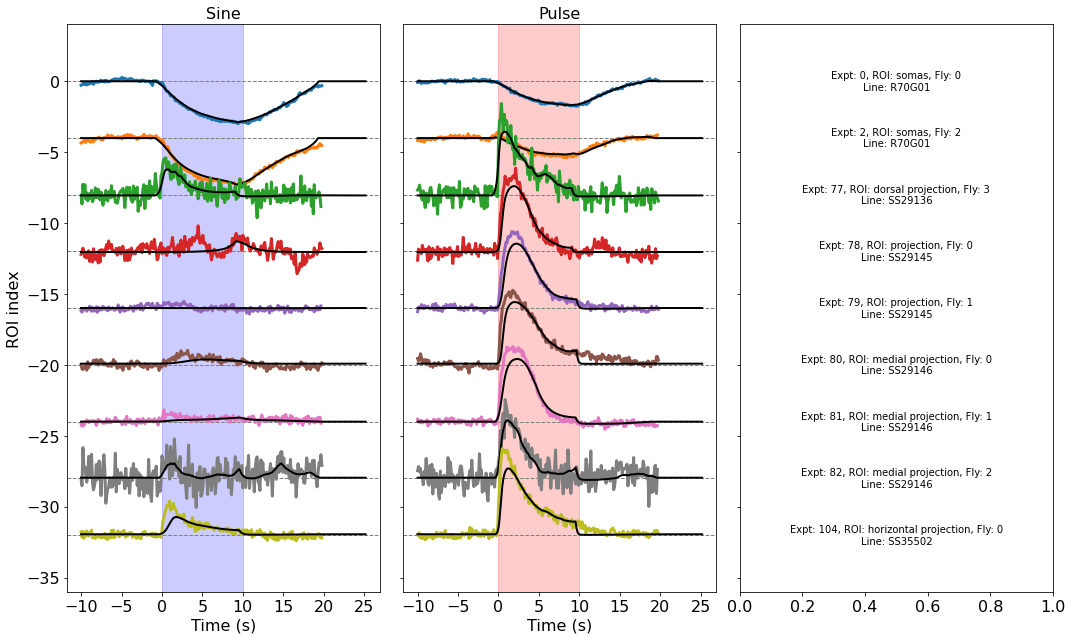

In [9]:
expt_ids_plot = [0, 2, 77, 78, 79, 80, 81, 82, 104]
# expt_ids_plot = [0, 2, 77, 78]
nroi_plot = len(expt_ids_plot)
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, ROI: {roi}, Fly: {fly}\nLine: {line}', ha='center', va='center')
    
    # prediction
    ## sine response
    row_s = df_pred_lnr[(df_pred_lnr['EXPT_ID'] == expt_id) & (df_pred_lnr['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_lnr[(df_pred_lnr['EXPT_ID'] == expt_id) & (df_pred_lnr['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)

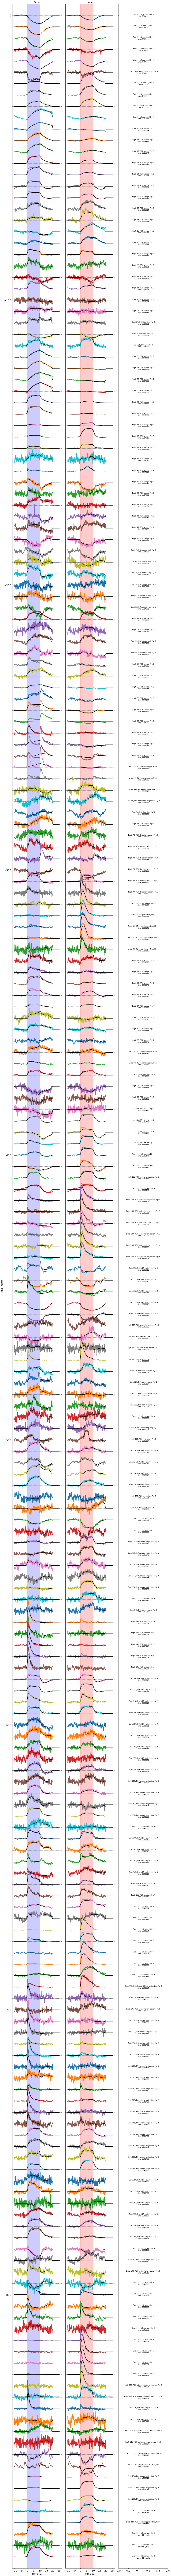

In [10]:
expt_ids_plot = range(len(df_param_lnr))
nroi_plot = len(expt_ids_plot)
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, ROI: {roi}, Fly: {fly}\nLine: {line}', ha='center', va='center')
    
    # prediction
    ## sine response
    row_s = df_pred_lnr[(df_pred_lnr['EXPT_ID'] == expt_id) & (df_pred_lnr['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_lnr[(df_pred_lnr['EXPT_ID'] == expt_id) & (df_pred_lnr['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)

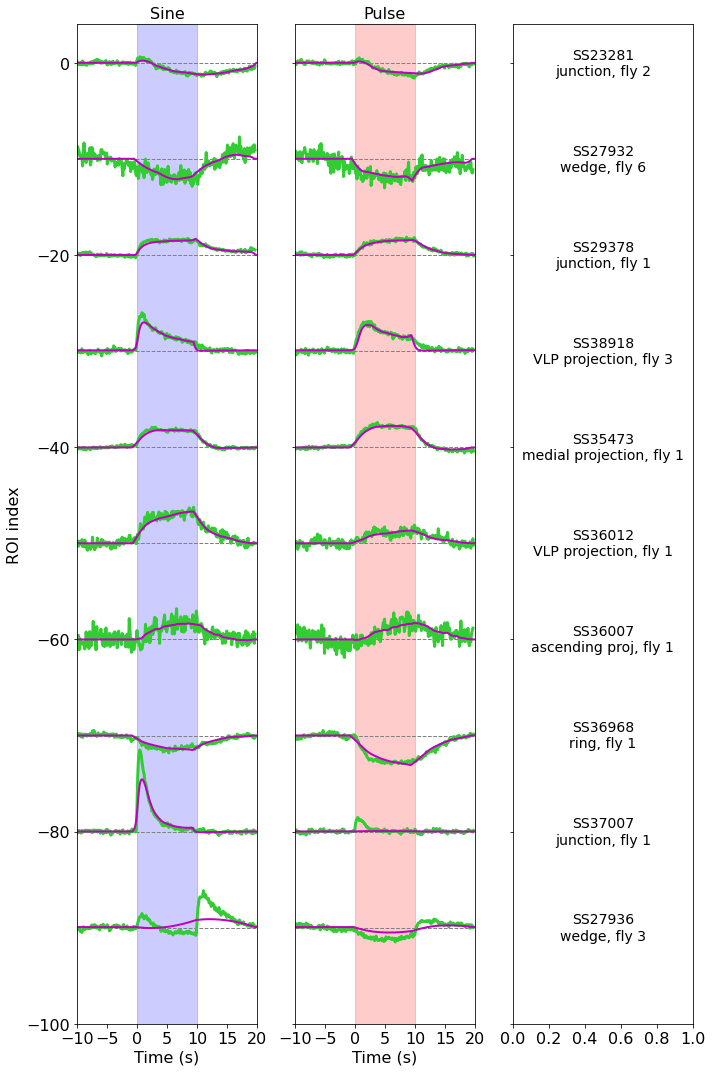

In [11]:
expt_ids_plot = [28, 46, 93, 148, 102, 126, 124, 132, 141, 65]
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(10, 1.5*len(expt_ids_plot)), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].axhline(-10*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 10*cexpt, lw=3, c='limegreen')
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-10*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 10*cexpt, lw=3, c='limegreen')
    
    axs[2].text(0.5, -10*cexpt, f'{line}\n{roi}, fly {fly+1}', ha='center', va='center', fontsize=14)
    
    # prediction
    ## sine response
    row_s = df_pred_lnr[(df_pred_lnr['EXPT_ID'] == expt_id) & (df_pred_lnr['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 10*cexpt, lw=2, c='m')
    
    ## pulse response
    row_p = df_pred_lnr[(df_pred_lnr['EXPT_ID'] == expt_id) & (df_pred_lnr['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 10*cexpt, lw=2, c='m')
    
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_xlim(-10, 20)
    ax.set_ylim(-10*len(expt_ids_plot), 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)